In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [83]:
def analyze_prototype(image_path, min_threshold=10):
    """
    Analyze the prototype:
    - Detect horizontal lines
    - Apply noise cleaning:
        * discard slanted lines
        * discard very close duplicates (< min_threshold)
    - Calculate the header height as the largest distance
    - Calculate the row height as the second largest distance
    """
    def to_scalar(x):
        if isinstance(x, (np.generic,)):
            return x.item()
        if isinstance(x, np.ndarray):
            return x.flatten()[0]
        return x

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading prototype: '{image_path}'")
        return 0, 0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)[1]

    # --- Detect horizontal lines ---
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    morph_horiz = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel)
    horiz_lines = cv2.HoughLinesP(morph_horiz, 1, np.pi/180, 30,
                                  minLineLength=50, maxLineGap=10)

    header_height = 0
    row_height = 0

    if horiz_lines is not None:
        horizontals = [l for l in horiz_lines if abs(l[0][1] - l[0][3]) < 1]
        horizontals = sorted(horizontals, key=lambda l: l[0][1])

        rows = []
        for l in horizontals:
            _, y1, _, y2 = l[0]
            y_avg = (y1 + y2) // 2
            if not rows or (y_avg - rows[-1]) > min_threshold:
                rows.append(y_avg)

        if len(rows) > 1:
            distances = [rows[i+1] - rows[i] for i in range(len(rows)-1)]
            print("Clean distances detected:", distances)

            header_height = max(distances)
            distances_wo_header = [d for d in distances if d != header_height]
            if distances_wo_header:
                row_height = max(distances_wo_header)

    return float(to_scalar(header_height)), round(float(to_scalar(row_height)))

In [84]:
def find_and_draw_table(screenshot_path, header_proto, row_proto, scale):
    """
    Generate table in screenshot based on header and row heights from prototype.
    Colors:
    - Entire table -> red
    - Header -> green
    - Rows -> yellow
    - Columns -> black
    """
    image = cv2.imread(screenshot_path)
    if image is None:
        print(f"ERROR: Could not load image '{screenshot_path}'")
        return

    output_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect vertical lines
    thresh = cv2.threshold(gray, 247, 255, cv2.THRESH_BINARY_INV)[1]
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    morph_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel)
    lines = cv2.HoughLinesP(morph_image, 1, np.pi/180, 20,
                            minLineLength=50, maxLineGap=40)

    if lines is None:
        print(f"No vertical lines found in '{screenshot_path}'")
        return

    verticals = [l for l in lines if abs(l[0][0] - l[0][2]) < 1]
    if not verticals:
        print(f"No pure vertical lines found in '{screenshot_path}'")
        return

    verticals = sorted(verticals, key=lambda l: l[0][0])
    first_line = verticals[0]
    x_first, y_top, _, y_bottom = first_line[0]
    x_last = verticals[-1][0][0]

    x1, x2 = sorted([x_first, x_last])
    y1, y2 = sorted([y_top, y_bottom])
    roi_height = y2 - y1

    # Scale measurements
    header_scaled = int(round(header_proto * scale))
    row_scaled = int(round(row_proto * scale))

    # Draw full table rectangle -> red
    cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Draw header -> green
    cv2.line(output_image, (x1, y1 + header_scaled),
             (x2, y1 + header_scaled), (0, 255, 0), 2)

    # Draw rows -> yellow
    y_current = header_scaled + row_scaled
    while y_current < roi_height:
        cv2.line(output_image, (x1, y1 + y_current),
                 (x2, y1 + y_current), (0, 255, 255), 2)
        y_current += row_scaled

    # Draw columns -> black
    for l in verticals:
        x_v, y1_v, _, y2_v = l[0]
        cv2.line(output_image, (x_v, y1), (x_v, y2), (0, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.title(f"Generated table in '{screenshot_path}'")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.show()

Clean distances detected: [np.int32(11), np.int32(11), np.int32(21), np.int32(22)]
Clean distances detected: [np.int32(73), np.int32(36), np.int32(44), np.int32(15), np.int32(36), np.int32(36)]


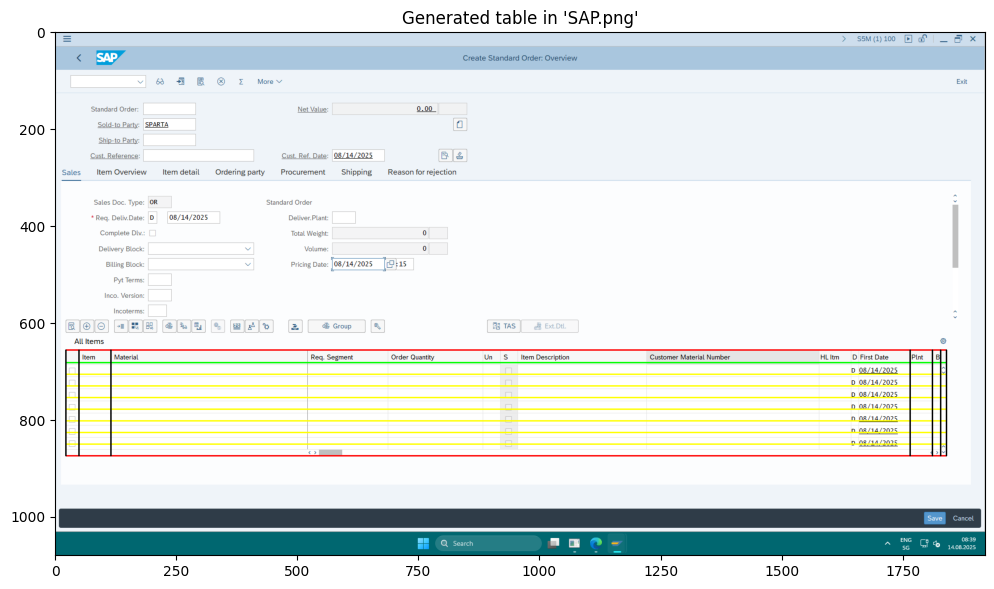

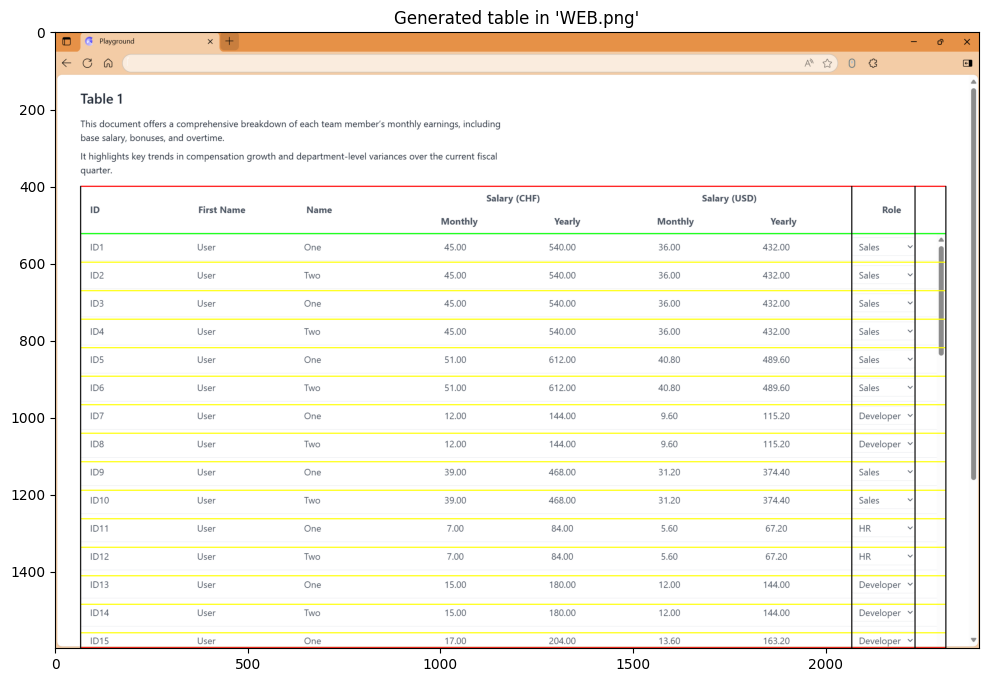

In [85]:
header_sap_proto, row_sap_proto = analyze_prototype("prototype_SAP.png")
header_web_proto, row_web_proto = analyze_prototype("prototype_WEB.png")

sap_screen_width = cv2.imread("SAP.png").shape[1]
web_screen_width = cv2.imread("WEB.png").shape[1]

sap_proto_width = cv2.imread("prototype_SAP.png").shape[1]
web_proto_width = cv2.imread("prototype_WEB.png").shape[1]

scale_sap = sap_screen_width / sap_proto_width if sap_proto_width > 0 else 1
scale_web = web_screen_width / web_proto_width if web_proto_width > 0 else 1

find_and_draw_table("SAP.png", header_sap_proto, row_sap_proto, scale_sap)
find_and_draw_table("WEB.png", header_web_proto, row_web_proto, scale_web)
